In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline

import os
import sys
from pathlib import Path
from pprint import pprint
import pickle
from scipy.optimize import curve_fit

from utils import analysis, utils, files # sibling package...

bars
- variance compared to movements
- explained by movements?
- height of target bar vs height of other bars? (some type of score)
- "shape" of bar data overall? 
  - dimensionality
  - ...?
- search strategy (dynamical modes?)

targets
- dimensionality
- search strategy
- comparison to natural movements (what movements are you making per target?)

In [2]:
def get_session_path_list(experiment, subject):
    path_dictionary = files.build_experiment_path_dict(experiment)
    session_dict = path_dictionary["subjects"][subject]["tasks"]["center_hold"]["sessions"]
    session_path_list = []

    for session in sorted(list(session_dict.keys()),key=lambda x: int(x.split("_")[-1])):
        session_path_list.append(session_dict[session])
    return session_path_list

def get_outcomes(experiment, subject):
    session_path_list = get_session_path_list(experiment, subject)
    num_sessions = len(session_path_list)
    hits = []
    misses = []
    noholds = []
    reach_times = []
    for behavior_path in session_path_list:
        outcome_path = [x for x in behavior_path.iterdir() if "result" in x.name][0]
        behavior = np.genfromtxt(str(outcome_path), delimiter=',', skip_header=1, dtype=None, encoding=None)
        outcomes = [x[0] for x in behavior]
        for x in behavior:
            if x[0] == "Hit":
                reach_times.append(x[2])
        uniques, counts = np.unique(outcomes, return_counts=True)
        for outcome, count in zip(uniques, counts):
            if outcome == "Hit":
                hits.append(count)
            elif outcome == "Miss":
                misses.append(count)
            elif outcome == "No Hold":
                noholds.append(count)
            else:
                raise ValueError("Unforeseen outcome in behavior: ", outcome)
        if "Hit" not in outcomes:
            hits.append(0)
        if "Miss" not in outcomes:
            misses.append(0)
        if "No Hold" not in outcomes:
            noholds.append(0)
    return hits, misses, noholds, num_sessions

def get_subjects(experiment, removed=None):
    folder = utils.get_experiment_data_folder(experiment)
    if removed is None:
        return [f.name for f in folder.iterdir()]
    else:
        return [f.name for f in folder.iterdir() if f.name not in removed]

def log(x, a, b):
    return b * np.log(x) + a

In [3]:
olympics_subjects = get_subjects("emg_olympics", removed=[])
olympics_aliases = {
    "jesse":"Placid Owner",
    "lars":"Luxury Boot",
    "bob":"Beaded Microchip",
    "peter":"Petty Driver" ,
    "miranda":"Reflective Director",
    "dammy":"Breezy Door",
    "oriol":"Crouching Turtle",
    "nate":"Hungry Tree",
    "april": "Decisive Apple",
    "zane":"Jubilant Butterfly",
    "georgia":"Pouncing Daffodil",
    "holly":"Reparable Semiconductor", 
    "alba":"Gregarious Stone",
    "svenja":"Benevolent Newspaper",
    "philip":"Dappled Stamp",
    "tom":"Dangling Cunieform",
    "lucas":"Fruitful Lorry",
    "fede":"Turbulent Stew",
    "andrei":"Drafty Elbow",
    "andy":"Striped Bottle",
    "peterg":"Scented Shovel",
    "emmett":"Serious Rainbow",
    "aeron":"aeron",
    "jai":"jai",
    "chiyu":"chiyu",
    "peterv":"peter",
    "egzona":"egzona",
    "arthur":"arthur",
    "will":"will",
    "clem":"clem",
    "daniel":"daniel",
    "zeynib":"zeynib",
    "elena":"elena",
    "hyewon": "hyewon",
    "sarah": "sarah",
    "nicole": "nicole",
    "rodrigo": "rodrigo",
    "lara": "lara",
    "viktor":"viktor",
    "hernando": "hernando",
    "marta": "marta",
    "mattias":"mattias"
}

print(f"num subjects: {len(olympics_subjects)}:")
for subject in olympics_subjects:
    if subject not in list(olympics_aliases.keys()):
        print(f"NO ALIAS: ", subject)
    else:
        print(subject, "AKA", olympics_aliases[subject])

repeat_subjects = get_subjects("emg_repeats", removed=[])
repeat_aliases = {
    "zane":"zane 2",
    "holly": "holly 2",
    "miranda": "miranda 2",
    "alba":"alba 2"
}

print(f"num subjects: {len(repeat_subjects)}:")
for subject in repeat_subjects:
    if subject not in list(repeat_aliases.keys()):
        print(f"NO ALIAS: ", subject)
    else:
        print(subject, "AKA", repeat_aliases[subject])

num subjects: 41:
aeron AKA aeron
alba AKA Gregarious Stone
andrei AKA Drafty Elbow
andy AKA Striped Bottle
april AKA Decisive Apple
arthur AKA arthur
bob AKA Beaded Microchip
chiyu AKA chiyu
clem AKA clem
dammy AKA Breezy Door
daniel AKA daniel
egzona AKA egzona
elena AKA elena
emmett AKA Serious Rainbow
fede AKA Turbulent Stew
georgia AKA Pouncing Daffodil
hernando AKA hernando
holly AKA Reparable Semiconductor
hyewon AKA hyewon
jai AKA jai
jesse AKA Placid Owner
lara AKA lara
lars AKA Luxury Boot
lucas AKA Fruitful Lorry
marta AKA marta
mattias AKA mattias
miranda AKA Reflective Director
nate AKA Hungry Tree
nicole AKA nicole
oriol AKA Crouching Turtle
peterg AKA Scented Shovel
peterv AKA peter
philip AKA Dappled Stamp
rodrigo AKA rodrigo
sarah AKA sarah
svenja AKA Benevolent Newspaper
tom AKA Dangling Cunieform
viktor AKA viktor
will AKA will
zane AKA Jubilant Butterfly
zeynib AKA zeynib
num subjects: 4:
alba AKA alba 2
holly AKA holly 2
miranda AKA miranda 2
zane AKA zane 2


/tmp/ipykernel_12651/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a
/tmp/ipykernel_12651/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a
/tmp/ipykernel_12651/2440466779.py:19: UserWarning: genfromtxt: Empty input file: "/mnt/c/Users/spencer/data/emg_olympics/andrei/center_hold/session_11/session_result_2021-09-29T17_30_57.csv"
  behavior = np.genfromtxt(str(outcome_path), delimiter=',', skip_header=1, dtype=None, encoding=None)
/tmp/ipykernel_12651/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a
/tmp/ipykernel_12651/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a
/tmp/ipykernel_12651/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a
/tmp/ipykernel_12651/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a
/tmp/ipyk

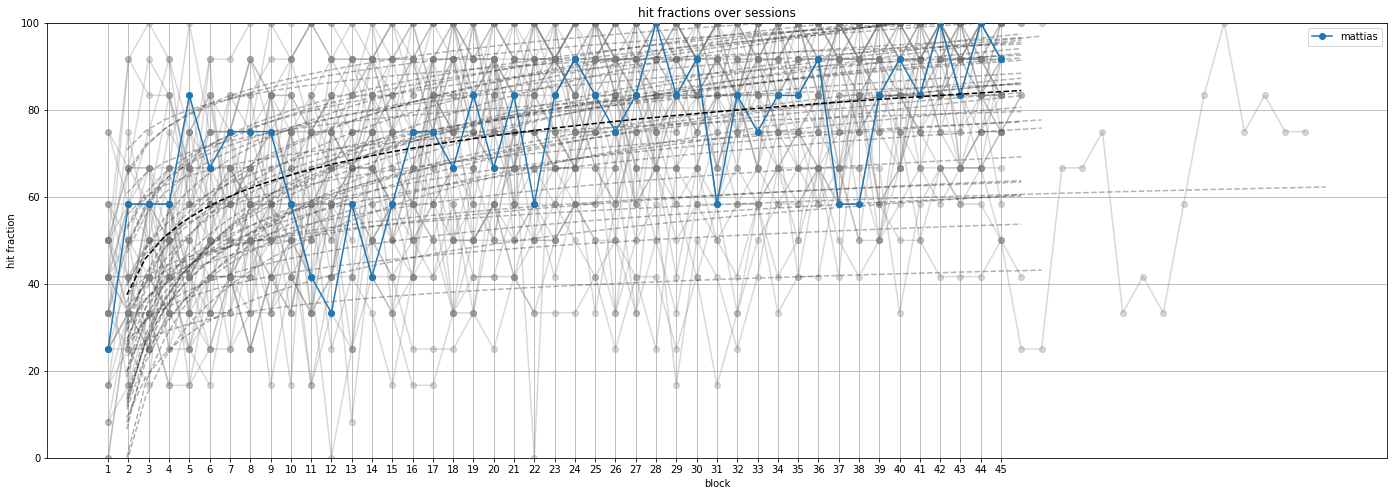

In [6]:
def plot_hit_curves(experiment, subjects, aliases, subjects_to_plot = [], ax = None):
    stats = []
    hf=[]
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(24,8))
    for subject in subjects:
        hits, misses, noholds, num_sessions = get_outcomes(experiment, subject)
        fractions = [h*(100/12) for h in hits]
        sessions_idxs = range(len(fractions))
        x = np.linspace(0,num_sessions,50)
        popt, pcov = curve_fit(log, list(range(1, num_sessions+1)), fractions)
        total_fraction = 100*sum(hits)/(num_sessions*12)
        stats.append(f"{aliases[subject]}: \n Hit Fraction: {round(total_fraction,1)}% \n Baseline: {round(popt[0],1)}% \n Rate: {round(popt[1],1)} \n")
        hf.append(total_fraction)
        if subject in subjects_to_plot:
            ax.plot(fractions , "-o", label=aliases[subject],zorder=10)
            plt.plot(x, log(x, *popt), 'k--',zorder=10)
        else:
            ax.plot(fractions , "-o", color="gray", alpha=0.3)
            plt.plot(x, log(x, *popt), 'k--', alpha=0.3)
    ax.set_xlabel("block")
    ax.set_ylabel("hit fraction")
    ax.set_title("hit fractions over sessions")
    ax.set_ylim([0,100])
    ax.set_xticks(range(num_sessions))
    ax.set_xticklabels(range(1,num_sessions+1))
    ax.grid()
    ax.legend()
    return ax, hf, stats


ax, hf, stats = plot_hit_curves("emg_olympics", olympics_subjects, olympics_aliases, subjects_to_plot = ["mattias"], ax = None)
# ax = plot_hit_curves("emg_repeats", repeat_subjects, repeat_aliases, subjects_to_plot = ["alba"], ax = ax)

In [5]:
for i in np.argsort(hf)[::-1]:
    print(stats[i])

Pouncing Daffodil: 
 Hit Fraction: 94.3% 
 Baseline: 65.5% 
 Rate: 9.9 

Dappled Stamp: 
 Hit Fraction: 92.2% 
 Baseline: 66.4% 
 Rate: 9.0 

aeron: 
 Hit Fraction: 89.3% 
 Baseline: 71.3% 
 Rate: 6.2 

Scented Shovel: 
 Hit Fraction: 89.1% 
 Baseline: 49.8% 
 Rate: 13.7 

jai: 
 Hit Fraction: 88.0% 
 Baseline: 49.3% 
 Rate: 13.5 

rodrigo: 
 Hit Fraction: 87.6% 
 Baseline: 37.2% 
 Rate: 17.6 

Turbulent Stew: 
 Hit Fraction: 86.1% 
 Baseline: 54.1% 
 Rate: 11.2 

Placid Owner: 
 Hit Fraction: 85.0% 
 Baseline: 27.7% 
 Rate: 20.0 

nicole: 
 Hit Fraction: 84.8% 
 Baseline: 30.6% 
 Rate: 18.9 

Striped Bottle: 
 Hit Fraction: 83.9% 
 Baseline: 48.2% 
 Rate: 12.4 

Luxury Boot: 
 Hit Fraction: 83.0% 
 Baseline: 53.4% 
 Rate: 10.3 

viktor: 
 Hit Fraction: 83.0% 
 Baseline: 21.5% 
 Rate: 21.4 

Crouching Turtle: 
 Hit Fraction: 80.2% 
 Baseline: 8.7% 
 Rate: 24.9 

chiyu: 
 Hit Fraction: 79.8% 
 Baseline: 61.4% 
 Rate: 6.4 

daniel: 
 Hit Fraction: 76.9% 
 Baseline: 13.7% 
 Rate: 22.0 

H

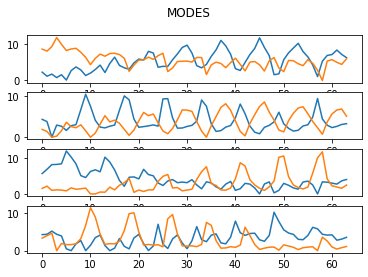

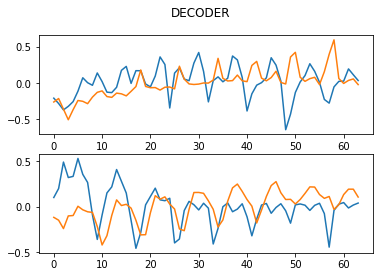

In [35]:
subject = "holly"
subject_metadata_folder = utils.get_subject_folder(experiment="emg_olympics", subject=subject)
with open(subject_metadata_folder / "nmf_model.pkl", 'rb') as fp:
    m = pickle.load(fp)

# subject_metadata = utils.get_subject_metadata("emg_olympics", subject)
modes = m.components_ # [subject_metadata["components"]]

fig, maxes = plt.subplots(4,1)
fig.suptitle("MODES")
for i, (ax, c) in enumerate(zip(maxes,modes)):
    ax.plot(c)
    
decoder = utils.load_array_from_disk(subject_metadata_folder / "decoder.bin").reshape(6,64)[-2:,:]
fig, daxes = plt.subplots(2,1)
fig.suptitle("DECODER")
for ax, d in zip(daxes, decoder):
    ax.plot(d)

subject_metadata_folder = utils.get_subject_folder(experiment="emg_repeats", subject=subject)
with open(subject_metadata_folder / "nmf_model.pkl", 'rb') as fp:
    m = pickle.load(fp)

# subject_metadata = utils.get_subject_metadata("emg_repeats", subject)
modes = m.components_ # [subject_metadata["components"]]
maxes[0].plot(modes[0,:])
maxes[1].plot(modes[1,:])
maxes[2].plot(modes[2,:])
maxes[3].plot(modes[3,:])

decoder = utils.load_array_from_disk(subject_metadata_folder / "decoder.bin").reshape(6,64)[-2:,:]
daxes[0].plot(decoder[0,:])
daxes[1].plot(decoder[1,:])